# Eksperimen Backtest Strategi Harian

Notebook ringkas untuk menjalankan satu strategi harian menggunakan pipeline terpusat.


In [1]:
from __future__ import annotations

import json
import sys
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

if not hasattr(matplotlib.rcParams, '_get'):
    def _rcparams_get(key, default=None):
        return matplotlib.rcParams.get(key, default)
    matplotlib.rcParams._get = _rcparams_get



def locate_project_root() -> Path:
    current = Path.cwd().resolve()
    for candidate in (current, *current.parents):
        if (candidate / "src").exists():
            return candidate
    raise RuntimeError("Folder 'src' tidak ditemukan dari jalur kerja sekarang.")


PROJECT_ROOT = locate_project_root()
SRC_PATH = PROJECT_ROOT / "src"
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.pipelines.single_asset import (
    IndicatorConfig,
    SingleAssetPipelineConfig,
    run_single_asset_pipeline,
    save_backtest_outputs,
)


In [2]:
CONFIG = {
    "data_path": PROJECT_ROOT / "data/OKX_ETHUSDT.P, 60.csv",
    "strategy_name": "vwap",
    "strategy_kwargs": {},
    "price_column": "close",
    "horizon_bars": None,
    "indicators": [],
    "output_dir": PROJECT_ROOT / "outputs",
    "output_prefix": "backtest_strategy",
    "save_outputs": True,
}

PIPELINE_CONFIG = SingleAssetPipelineConfig(
    data_path=str(CONFIG['data_path']),
    strategy_name=CONFIG['strategy_name'],
    strategy_kwargs=CONFIG.get('strategy_kwargs', {}),
    horizon_bars=CONFIG.get('horizon_bars'),
    indicators=tuple(IndicatorConfig(**item) for item in CONFIG.get('indicators', [])),
    price_column=CONFIG.get('price_column', 'close'),
)

OUTPUT_DIR = CONFIG.get('output_dir', PROJECT_ROOT / 'outputs')
OUTPUT_PREFIX = CONFIG.get('output_prefix', 'backtest')
SAVE_OUTPUTS = bool(CONFIG.get('save_outputs', False))

Ringkasan metrics:


,value
total_return,0.7511
cagr,1.8904
sharpe_ratio,2.3821
annualised_vol,0.4975
max_drawdown,-0.1967
avg_drawdown_duration,156.4138


Ringkasan trade:


,value
total_trades,48.0000
bars_in_market,2522.0000
bars_flat,2102.0000
time_in_market_pct,0.5454
flat_time_pct,0.4546
long_exposure_pct,0.2535
short_exposure_pct,0.2920
avg_position,-0.0385
avg_abs_position,0.5454
long_trades,30.0000


Total trades: 48
Sharpe Ratio: 2.3821
Artifacts tersimpan:
  - metrics: C:\Users\jefri\backtest\outputs\backtest_strategy_metrics.json
  - trades: C:\Users\jefri\backtest\outputs\backtest_strategy_trades.csv
  - plot: C:\Users\jefri\backtest\outputs\backtest_strategy_equity.png

Menampilkan equity curve dari artifact plot:


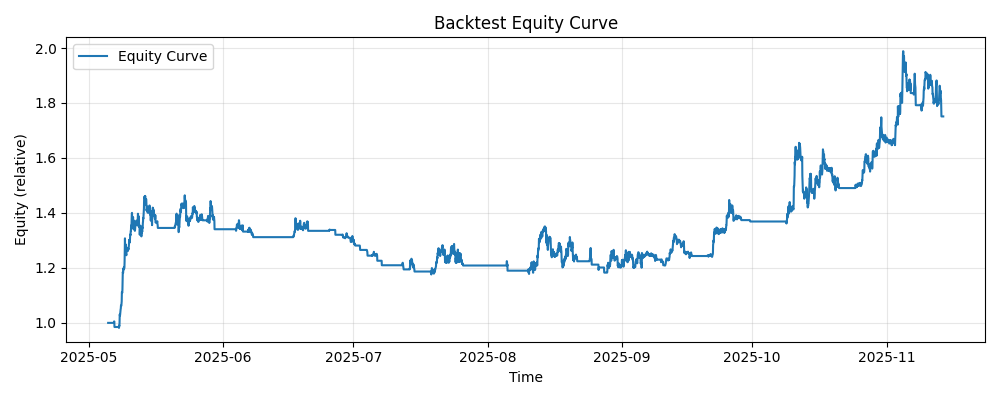

In [3]:
from IPython.display import Image

outputs = run_single_asset_pipeline(PIPELINE_CONFIG)

metrics_df = pd.Series(outputs.metrics, name="value").to_frame()
trade_summary_df = pd.Series(outputs.trade_summary, name="value").to_frame()

print("Ringkasan metrics:")
display(metrics_df.style.format({"value": "{:.4f}"}))

print("Ringkasan trade:")
display(trade_summary_df.style.format({"value": "{:.4f}"}))

print(f"Total trades: {outputs.trade_summary.get('total_trades', 0)}")
print(f"Sharpe Ratio: {outputs.metrics.get('sharpe_ratio'):.4f}")

if SAVE_OUTPUTS:
    artifacts = save_backtest_outputs(outputs, OUTPUT_DIR, prefix=OUTPUT_PREFIX)
    print("Artifacts tersimpan:")
    for name, path in artifacts.items():
        print(f"  - {name}: {path}")

    plot_artifact = artifacts.get("plot")
    if plot_artifact and Path(plot_artifact).exists():
        print("\nMenampilkan equity curve dari artifact plot:")
        display(Image(filename=str(plot_artifact)))
    else:
        print("Plot artifact tidak ditemukan atau tidak tersedia.")
else:
    print("SAVE_OUTPUTS = False, artifacts tidak dibuat.")


### Analisis tambahan: distribusi PnL & MAE/MFE


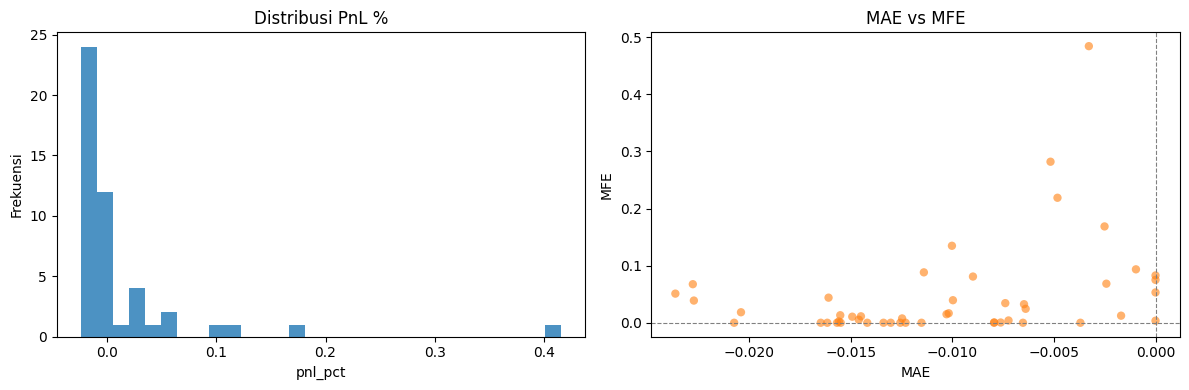

In [4]:
trade_data = getattr(outputs, 'trades', None)
if trade_data is None or trade_data.empty:
    print('Tidak ada data trade untuk divisualisasikan.')
else:
    pnl = trade_data.get('pnl_pct')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    if pnl is not None:
        axes[0].hist(pnl.dropna(), bins=30, color='#1f77b4', alpha=0.8)
        axes[0].set_title('Distribusi PnL %')
        axes[0].set_xlabel('pnl_pct')
        axes[0].set_ylabel('Frekuensi')
    else:
        axes[0].text(0.5, 0.5, 'Kolom pnl_pct tidak tersedia', transform=axes[0].transAxes, ha='center')

    mae = trade_data.get('mae')
    mfe = trade_data.get('mfe')
    if mae is not None and mfe is not None:
        mae_mfe = pd.DataFrame({'mae': mae, 'mfe': mfe}).dropna()
        if mae_mfe.empty:
            axes[1].text(0.5, 0.5, 'Tidak ada data MAE/MFE', transform=axes[1].transAxes, ha='center')
        else:
            axes[1].scatter(mae_mfe['mae'], mae_mfe['mfe'], alpha=0.6, color='#ff7f0e', edgecolor='none')
    else:
        axes[1].text(0.5, 0.5, 'Kolom MAE/MFE tidak ditemukan', transform=axes[1].transAxes, ha='center')
    axes[1].set_title('MAE vs MFE')
    axes[1].set_xlabel('MAE')
    axes[1].set_ylabel('MFE')
    axes[1].axhline(0, color='grey', linewidth=0.8, linestyle='--')
    axes[1].axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.tight_layout()
    plt.show()


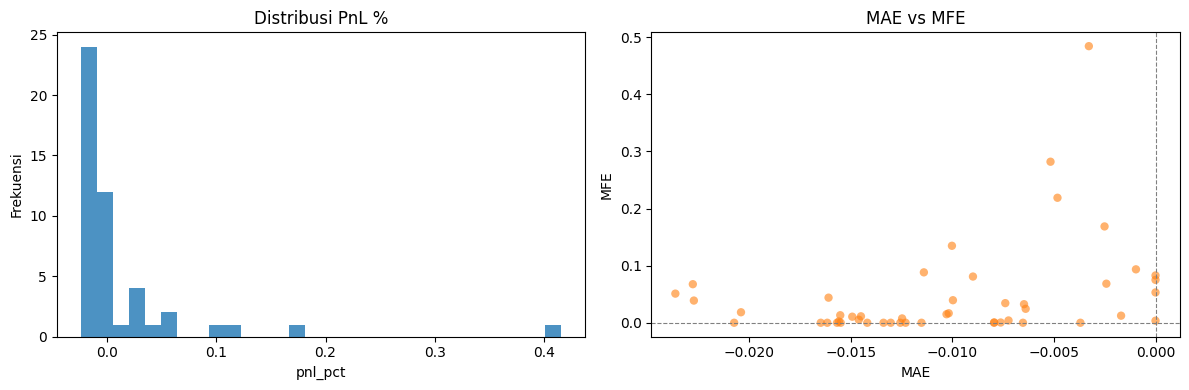

In [5]:
trade_data = getattr(outputs, 'trades', None)
if trade_data is None or trade_data.empty:
    print('Tidak ada data trade untuk divisualisasikan.')
else:
    pnl = trade_data.get('pnl_pct')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    if pnl is not None:
        axes[0].hist(pnl.dropna(), bins=30, color='#1f77b4', alpha=0.8)
        axes[0].set_title('Distribusi PnL %')
        axes[0].set_xlabel('pnl_pct')
        axes[0].set_ylabel('Frekuensi')
    else:
        axes[0].text(0.5, 0.5, 'Kolom pnl_pct tidak tersedia', transform=axes[0].transAxes, ha='center')

    mae = trade_data.get('mae')
    mfe = trade_data.get('mfe')
    if mae is not None and mfe is not None:
        mae_mfe = pd.DataFrame({'mae': mae, 'mfe': mfe}).dropna()
        if mae_mfe.empty:
            axes[1].text(0.5, 0.5, 'Tidak ada data MAE/MFE', transform=axes[1].transAxes, ha='center')
        else:
            axes[1].scatter(mae_mfe['mae'], mae_mfe['mfe'], alpha=0.6, color='#ff7f0e', edgecolor='none')
    else:
        axes[1].text(0.5, 0.5, 'Kolom MAE/MFE tidak ditemukan', transform=axes[1].transAxes, ha='center')
    axes[1].set_title('MAE vs MFE')
    axes[1].set_xlabel('MAE')
    axes[1].set_ylabel('MFE')
    axes[1].axhline(0, color='grey', linewidth=0.8, linestyle='--')
    axes[1].axvline(0, color='grey', linewidth=0.8, linestyle='--')
    plt.tight_layout()
    plt.show()


In [6]:
from pathlib import Path
import importlib.util
import pandas as pd
from datetime import datetime, timezone
try:
    PROJECT_ROOT
except NameError:  # pragma: no cover - notebook convenience
    PROJECT_ROOT = Path.cwd()



def export_tables_to_excel(tables, path: Path) -> Path:
    def strip_timezone_from_value(value):
        if value is pd.NaT:
            return value
        if isinstance(value, pd.Timestamp):
            if value.tz is not None:
                return value.tz_convert("UTC").tz_localize(None)
            return value
        if isinstance(value, datetime):
            if value.tzinfo is not None:
                return value.astimezone(timezone.utc).replace(tzinfo=None)
            return value
        return value

    def strip_timezone_from_axis(axis):
        if isinstance(axis, pd.MultiIndex):
            new_levels = [strip_timezone_from_axis(level) for level in axis.levels]
            return axis.set_levels(new_levels)
        if isinstance(axis, pd.DatetimeIndex) and axis.tz is not None:
            return axis.tz_convert("UTC").tz_localize(None)
        if getattr(axis, "dtype", None) == object:
            return pd.Index([strip_timezone_from_value(val) for val in axis], name=axis.name)
        return axis

    def make_excel_safe(frame: pd.DataFrame) -> pd.DataFrame:
        frame = frame.copy()
        frame.index = strip_timezone_from_axis(frame.index)
        frame.columns = strip_timezone_from_axis(frame.columns)
        for column in frame.columns:
            series = frame[column]
            if isinstance(series.dtype, pd.DatetimeTZDtype):
                frame[column] = series.dt.tz_convert("UTC").dt.tz_localize(None)
            elif series.dtype == object:
                frame[column] = series.map(strip_timezone_from_value)
        return frame

    serialisable = []
    for sheet_name, table in tables.items():
        if table is None:
            continue
        if isinstance(table, pd.Series):
            frame = table.to_frame()
        elif isinstance(table, pd.DataFrame):
            frame = table.copy()
        elif isinstance(table, dict):
            frame = pd.DataFrame([table])
        else:
            frame = pd.DataFrame(table)
        frame = make_excel_safe(frame)
        serialisable.append((sheet_name, frame))

    if not serialisable:
        raise ValueError("Tidak ada tabel yang bisa diekspor.")

    path.parent.mkdir(parents=True, exist_ok=True)

    def pick_engine() -> str:
        for candidate in ("openpyxl", "xlsxwriter"):
            if importlib.util.find_spec(candidate):
                return candidate
        raise ModuleNotFoundError(
            "Untuk ekspor Excel diperlukan paket 'openpyxl' atau 'xlsxwriter'."
        )

    def normalise_sheet_name(name: str, existing) -> str:
        safe = (name or "Sheet").strip() or "Sheet"
        safe = safe[:31]
        counter = 1
        candidate = safe
        while candidate in existing:
            suffix = f"_{counter}"
            trimmed = safe[: 31 - len(suffix)] or "Sheet"
            candidate = f"{trimmed}{suffix}"
            counter += 1
        existing.add(candidate)
        return candidate

    engine = pick_engine()
    used_names = set()
    with pd.ExcelWriter(path, engine=engine) as writer:
        for sheet_name, frame in serialisable:
            name = normalise_sheet_name(str(sheet_name), used_names)
            frame.to_excel(writer, sheet_name=name, index=True)

    print(
        f"Berhasil mengekspor {len(serialisable)} sheet ke {path} (engine: {engine})"
    )
    return path
export_dir = PROJECT_ROOT / "outputs" / "result-test"
export_path = export_dir / "backtest-strategy.xlsx"

export_tables_to_excel(
    {
        "metrics": metrics_df,
        "trade_summary": trade_summary_df,
        "equity_curve": outputs.results,
        "positions": outputs.positions.to_frame(name="position"),
        "trades": outputs.trades,
    },
    export_path,
)



Berhasil mengekspor 5 sheet ke C:\Users\jefri\backtest\outputs\result-test\backtest-strategy.xlsx (engine: openpyxl)


WindowsPath('C:/Users/jefri/backtest/outputs/result-test/backtest-strategy.xlsx')